# Bayesian Homework 3

This notebook demonstrates three questions related to Bayesian inference with a **normal likelihood** and two different priors, as well as a conceptual discussion about multinomial-Dirichlet. Specifically:

- **Q1**: Implement a Gibbs sampler for a normal model with unknown mean and precision using a flat prior.
- **Q2**: Extend the Gibbs sampler to use a Normal-Gamma prior. Compare the impact of different prior hyperparameters. 
- **Q3**: Generate posterior predictive samples and visualize the uncertainty in future predictions.

We begin by importing the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, gamma

## **Q1: Gibbs Sampler with Flat Prior**
### **Problem Statement**
We assume that observations \( x_i \) follow a normal distribution:

\[
x_i \sim \text{Normal}(\theta, 1/\tau), \quad i = 1, \dots, n
\]

- The prior for \( \theta \) and \( \tau \) is **flat**:
  \[
  p(\theta, \tau) \propto 1
  \]
- The goal is to implement a **Gibbs sampler** that alternates between:
  1. Sampling \( \theta \) given \( \tau \).
  2. Sampling \( \tau \) given \( \theta \).

In [5]:
def gibbs_sampler_flat_prior(x, num_iter=5000, init_theta=0.0, init_tau=1.0):
    """
    Gibbs sampler for:
      x_i ~ Normal(mean=theta, variance=1/tau)
      Flat prior on (theta, tau)
    """
    n = len(x)
    theta_chain = np.zeros(num_iter)
    tau_chain   = np.zeros(num_iter)
    
    # Initialize
    theta_chain[0] = init_theta
    tau_chain[0]   = init_tau
    
    for g in range(1, num_iter):
        # (1) Sample theta
        curr_tau = tau_chain[g-1]
        mean_theta = np.mean(x)
        var_theta = 1.0 / (curr_tau * n)
        theta_chain[g] = norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))
        
        # (2) Sample tau
        curr_theta = theta_chain[g]
        shape_post = 0.5 * n
        rate_post  = 0.5 * np.sum((x - curr_theta)**2)
        tau_chain[g] = gamma.rvs(a=shape_post, scale=(1.0 / rate_post))
    
    return theta_chain, tau_chain

### **Run Gibbs Sampler (Flat Prior)**
We generate **synthetic data** from a normal distribution with \( \theta = 5 \) and variance \( 1/\tau = 1/1.5 \).

In [6]:
# Generate synthetic data
np.random.seed(42)
n_samples = 30
true_theta = 5.0
true_tau = 1.5  # Precision (1/variance)
x_data = norm.rvs(loc=true_theta, scale=np.sqrt(1/true_tau), size=n_samples)

# Run Gibbs sampler
theta_samples, tau_samples = gibbs_sampler_flat_prior(x_data, num_iter=3000)

# Compute posterior mean estimates
theta_est = np.mean(theta_samples[200:])  # Burn-in period
tau_est = np.mean(tau_samples[200:])

# Print results
print("Posterior mean estimate of theta:", theta_est)
print("Posterior mean estimate of tau:", tau_est)

Posterior mean estimate of theta: 4.839314835163433
Posterior mean estimate of tau: 1.8507860229633584


### **Plot the Markov Chains**

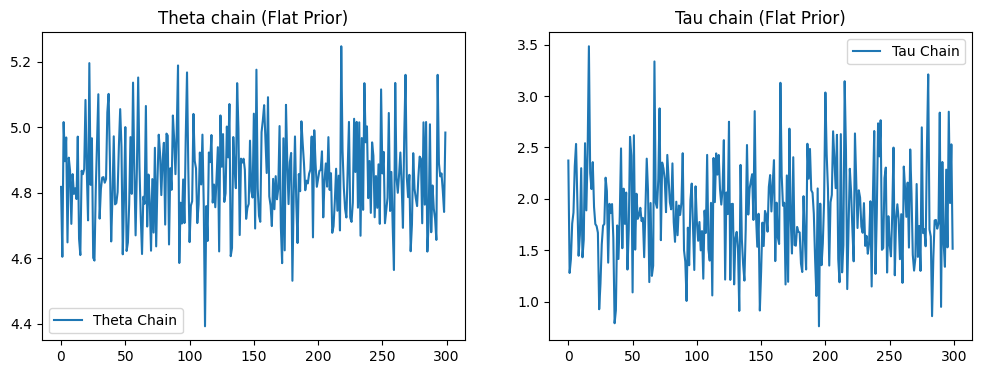

In [7]:
# Burn-in
burn_in = 200

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(theta_samples[burn_in:burn_in+300], label="Theta Chain")
axes[0].set_title("Theta chain (Flat Prior)")
axes[1].plot(tau_samples[burn_in:burn_in+300], label="Tau Chain")
axes[1].set_title("Tau chain (Flat Prior)")

for ax in axes:
    ax.legend()
plt.show()

## **Q2: Gibbs Sampler with Normal-Gamma Prior**
### **Problem Statement**
Now we extend the **Gibbs sampler** to use a **Normal-Gamma** prior:

- \( \theta \sim \text{Normal}(\theta_0, 1/\tau_0) \)
- \( \tau \sim \text{Gamma}(\alpha/2, \lambda/2) \)

This allows us to control **prior strength** and compare the impact of different hyperparameters.

In [8]:
def gibbs_sampler_normal_gamma(x, num_iter=5000,
                               init_theta=0.0, init_tau=1.0,
                               theta0=0.0, tau0=0.01,
                               alpha=3.0, lam=4.0):
    """
    Gibbs sampler for:
      x_i ~ Normal(mean=theta, variance=1/tau)
      theta ~ Normal(theta0, 1/tau0)
      tau ~ Gamma(alpha/2, lam/2)
    """
    n = len(x)
    theta_chain = np.zeros(num_iter)
    tau_chain   = np.zeros(num_iter)
    
    # Initialize
    theta_chain[0] = init_theta
    tau_chain[0]   = init_tau
    
    for g in range(1, num_iter):
        # (1) Sample theta
        curr_tau = tau_chain[g-1]
        sum_x    = np.sum(x)
        denom    = curr_tau * n + tau0
        var_theta = 1.0 / denom
        mu_theta  = (curr_tau * sum_x + tau0 * theta0) / denom
        theta_chain[g] = norm.rvs(loc=mu_theta, scale=np.sqrt(var_theta))
        
        # (2) Sample tau
        curr_theta = theta_chain[g]
        sum_sq = np.sum((x - curr_theta)**2)
        shape_post = 0.5 * (alpha + n)
        rate_post  = 0.5 * (lam + sum_sq)
        tau_chain[g] = gamma.rvs(a=shape_post, scale=(1.0 / rate_post))
    
    return theta_chain, tau_chain

### **Run Gibbs Sampler (Normal-Gamma Prior)**

In [9]:
theta_ng, tau_ng = gibbs_sampler_normal_gamma(
    x_data, num_iter=3000,
    init_theta=5.0, init_tau=1.0,
    theta0=0.0, tau0=0.01,
    alpha=3.0, lam=4.0
)

# Compute posterior mean estimates
theta_est_ng = np.mean(theta_ng[200:])
tau_est_ng = np.mean(tau_ng[200:])

# Print results
print("Posterior mean of theta (Normal-Gamma prior) =", theta_est_ng)
print("Posterior mean of tau (Normal-Gamma prior) =", tau_est_ng)

Posterior mean of theta (Normal-Gamma prior) = 4.845259067472652
Posterior mean of tau (Normal-Gamma prior) = 1.6290619978252883


### **Compare Markov Chains**

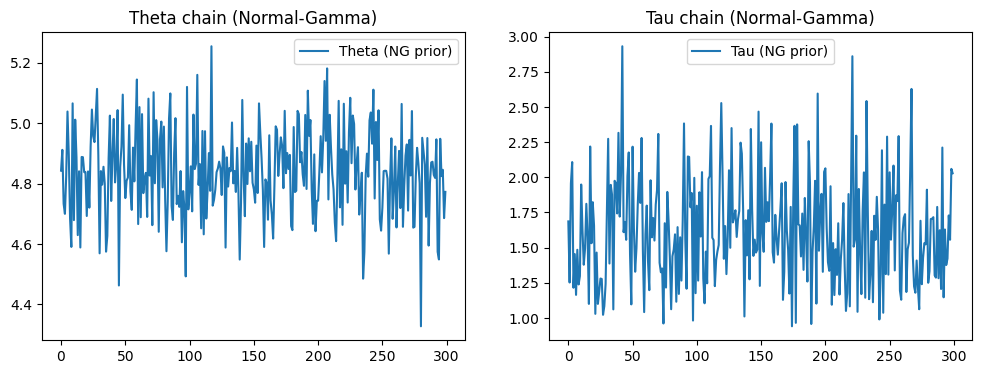

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(theta_ng[burn_in:burn_in+300], label="Theta (NG prior)")
axes[0].set_title("Theta chain (Normal-Gamma)")
axes[1].plot(tau_ng[burn_in:burn_in+300], label="Tau (NG prior)")
axes[1].set_title("Tau chain (Normal-Gamma)")

for ax in axes:
    ax.legend()
plt.show()

## **Q3: Posterior Predictive Distribution**

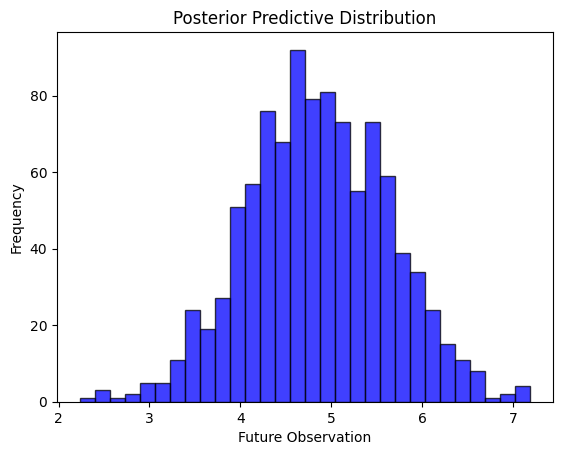

In [12]:
posterior_predictive_samples = norm.rvs(loc=theta_est_ng, scale=np.sqrt(1/tau_est_ng), size=1000)

plt.hist(posterior_predictive_samples, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.title("Posterior Predictive Distribution")
plt.xlabel("Future Observation")
plt.ylabel("Frequency")
plt.show()